# Data Inspection

Action items: `TODO`, `QUESTION`

#### Structure of this notebook:  
    **Exploring the data and descriptive statistics:**   

    A. Package and Data Load  
    B. Understanding the Likers & Retweeters datasets  
    C. Understanding script performance
    D. Understanding user activity

# A. Package and Data Load
Specify your data directory in this secion (`my_pull`).

In [1]:
import os
import glob
import json
import pandas as pd
import csv
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import itertools
from matplotlib import pyplot as plt
from collections import Counter
from ast import literal_eval
newest_pull_directory = max(glob.glob('../Pull*'), key=os.path.getmtime)
from aux import *

`my_pull`: Set the data directory you want to inspect, e.g. Pull-DD-MM-YYYY-hour:minute:second, or use the newest by setting `my_pull = newest_pull_directory`.

In [2]:
my_pull = newest_pull_directory
my_pull

'../Pull'

Load the data:

In [3]:
likers = pd.read_pickle(os.path.join(my_pull,'binary-matrix-likers.pkl'))
retweeters = pd.read_pickle(os.path.join(my_pull,'binary-matrix-retweeters.pkl'))
likers_complete = likers
retweeters_complete = retweeters
finalharvest_l = pd.read_pickle(os.path.join(my_pull,'likers_final_harvest_complete.pkl'))
finalharvest_r = pd.read_pickle(os.path.join(my_pull,'retweeters_final_harvest_complete.pkl'))
finalharvest_l.index.names = ['tweet']
finalharvest_r.index.names = ['tweet']

# B. Exploring

Let us look at the dataset of liking users, stored in  `likers`. In `likers`, the row index is tweet ID and the column names are user names. A cell contains `1` if the user liked the tweet, else `NaN`. Both rows and columns are sorted: rows numerically, columns alphabetically. The `retweeters` and `finalharvest_` dataframes are structured in the same way.

The next cells are examples of the following:

1. As the index is the tweet ID, we can look up a single tweet by using its ID, using `.loc`.
2. To find some tweet IDs, we may want to look up at the subsection of the first 3 tweets and the first 5 users, using `.iloc`.
3. TODO: List of linking users of a single tweet.

In [4]:
likers.loc[1537712147500781569]

00Skibsted         NaN
0neNin3Sierra      NaN
0ppermann          NaN
1000Tusindfryd     NaN
10ralphjade10      1.0
                  ... 
zeeemonnn          NaN
zevo_bte           NaN
zoega_b            NaN
zootopiavivared    NaN
zu_gabby           NaN
Name: 1537712147500781569, Length: 10530, dtype: float64

In [5]:
likers.iloc[0:3,0:5]

,00Skibsted,0neNin3Sierra,0ppermann,1000Tusindfryd,10ralphjade10
tweet,,,,,
1537359512163831808,NaN,NaN,NaN,NaN,NaN
1537360344863195136,NaN,NaN,NaN,NaN,NaN
1537360508596195330,NaN,NaN,NaN,NaN,NaN


## Summary Numbers

TODO: Write text

TODO: Comment in or delete.checkes

In [6]:
totals = pd.DataFrame()
totals.loc[1,'Tweets Liked'] = likers.shape[0]
totals.loc[1,'Likers'] = likers.shape[1]
totals.loc[1,'Likes'] = sum(likers.sum(axis = 1, skipna = True))
#totals.loc[1,'Sanity Check 1'] = sum(likers.sum(axis = 0, skipna = True))
totals.loc[1,'Tweets Retweeted'] = retweeters.shape[0]
totals.loc[1,'Retweeters'] = retweeters.shape[1]
totals.loc[1,'Retweets'] = sum(retweeters.sum(axis = 1, skipna = True))
#totals.loc[1,'Sanity Check 2'] = sum(retweeters.sum(axis = 0, skipna = True))
totals

,Tweets Liked,Likers,Likes,Tweets Retweeted,Retweeters,Retweets
1,1308.0,10530.0,28560.0,644.0,1802.0,3206.0


## C. Understanding script performance
### How many likers/retweeters did the script curate? We are looking at a dataset comprising those tweets that were also one last time collected in the final harvest

In [7]:
# Optional: How many tweets got <my_likersAtLeast> likes? How many tweets got <my_retweetersAtLeast> retweets?
# see parameters my_likersAtLeast/my_retweetersAtLeast
my_likersAtLeast = 10 # TODO SET YOUR PARAMTER HERE
my_retweetersAtLeast = 3 # TODO SET YOUR PARAMETER HERE

Atleast = pd.DataFrame()
Atleast.loc[1, 'All tweets liked'] = likers.shape[0]
Atleast.loc[1,'Tweets with my_likersAtLeast'] = sum((likers.sum(axis = 1, skipna = True)) >= my_likersAtLeast) 
Atleast.loc[1, 'All tweets retweeted'] = retweeters.shape[0]
Atleast.loc[1,'Tweets with my_retweetersAtLeast'] = sum((retweeters.sum(axis = 1, skipna = True)) >= my_retweetersAtLeast) 
Atleast

,All tweets liked,Tweets with my_likersAtLeast,All tweets retweeted,Tweets with my_retweetersAtLeast
1,1308.0,1184.0,644.0,607.0


In [8]:
subset_likerscomplete = pd.merge(likers_complete, finalharvest_l, left_index=True, right_index=True)
subset_retweeterscomplete = pd.merge(retweeters_complete, finalharvest_r, left_index=True, right_index=True)

In [9]:
# like count at time of final harvest
likecount = finalharvest_l['like_count']
# number of collected likers 
likerscollected = subset_likerscomplete.sum(axis = 1, skipna = True) 
# retweet count at time of final harvest
retweetcount = finalharvest_r['retweet_count']
# number of collected retweeters
retweeterscollected = subset_retweeterscomplete.sum(axis = 1, skipna = True) 

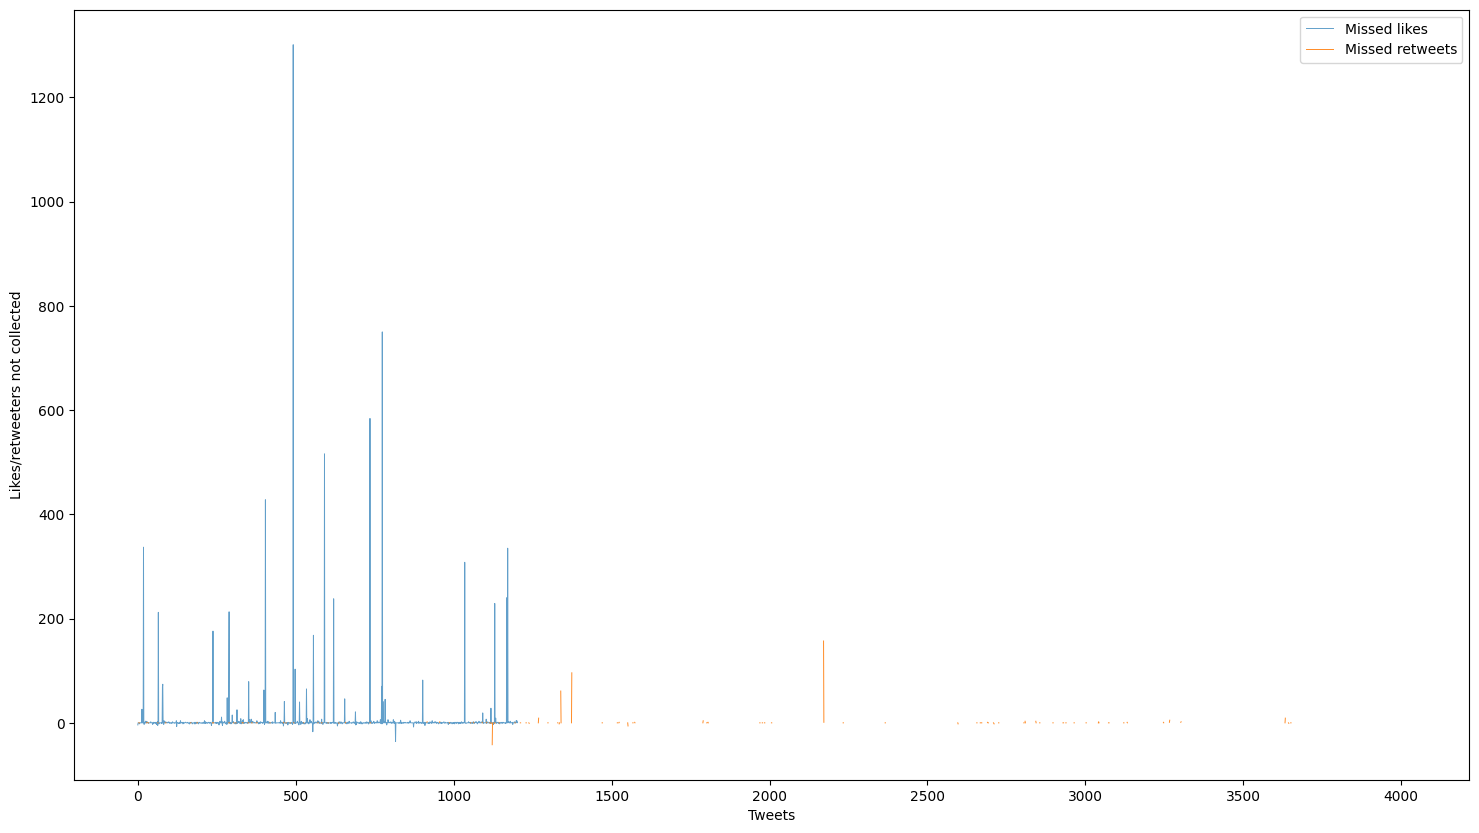

In [10]:
# Absolute number of missed likes/retweets per tweet
plot_missed(likecount, likerscollected, retweetcount, retweeterscollected)

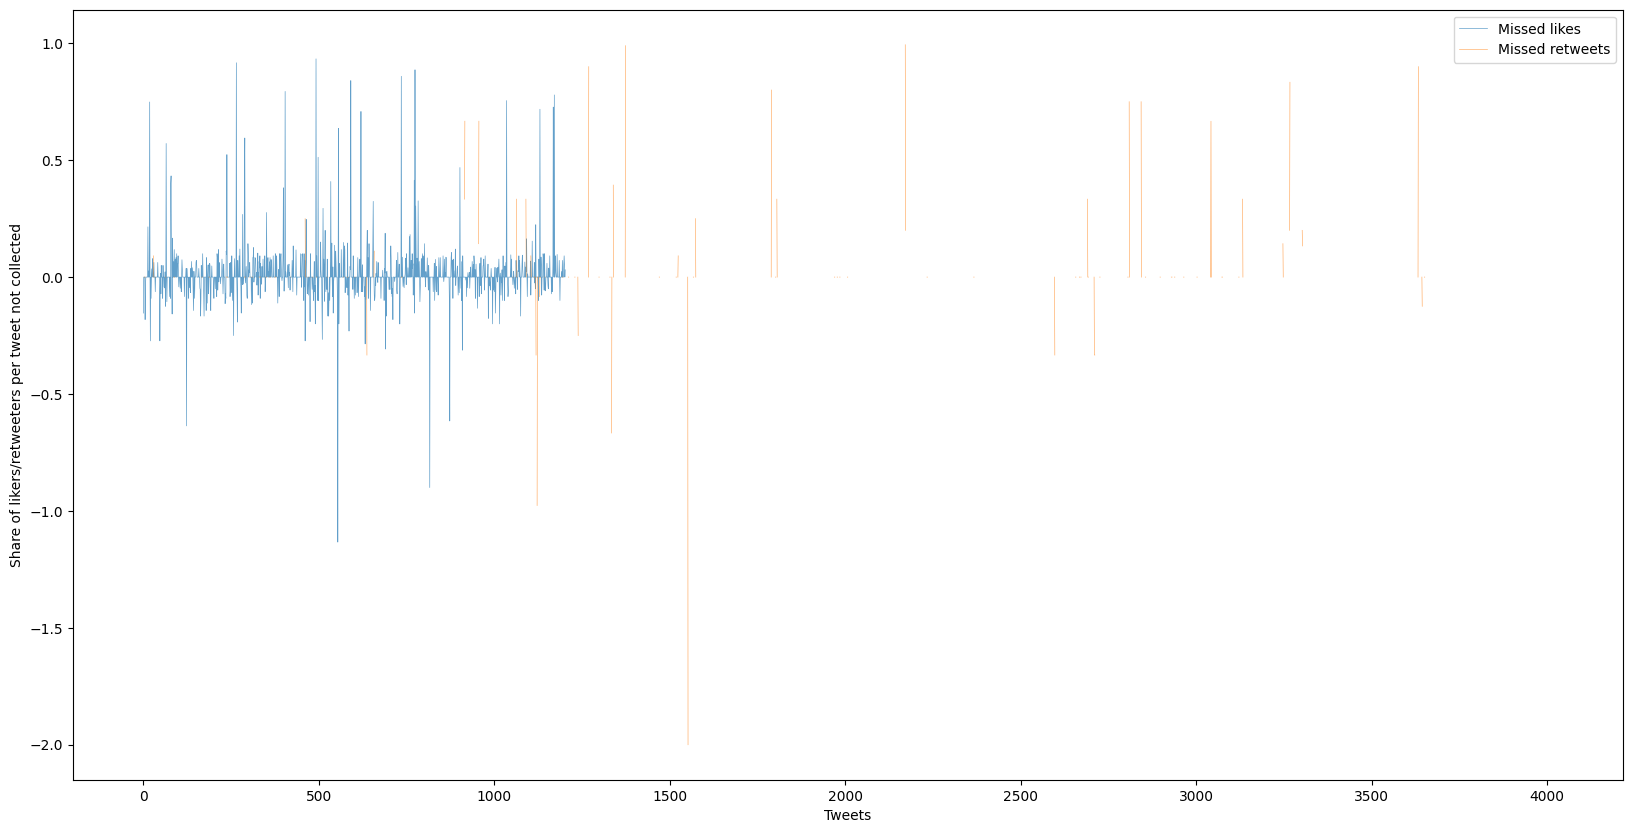

In [11]:
# Share of missed likes/retweets given total of received likes/retweets per tweet
plot_missed_relative(likecount, likerscollected, retweetcount, retweeterscollected)

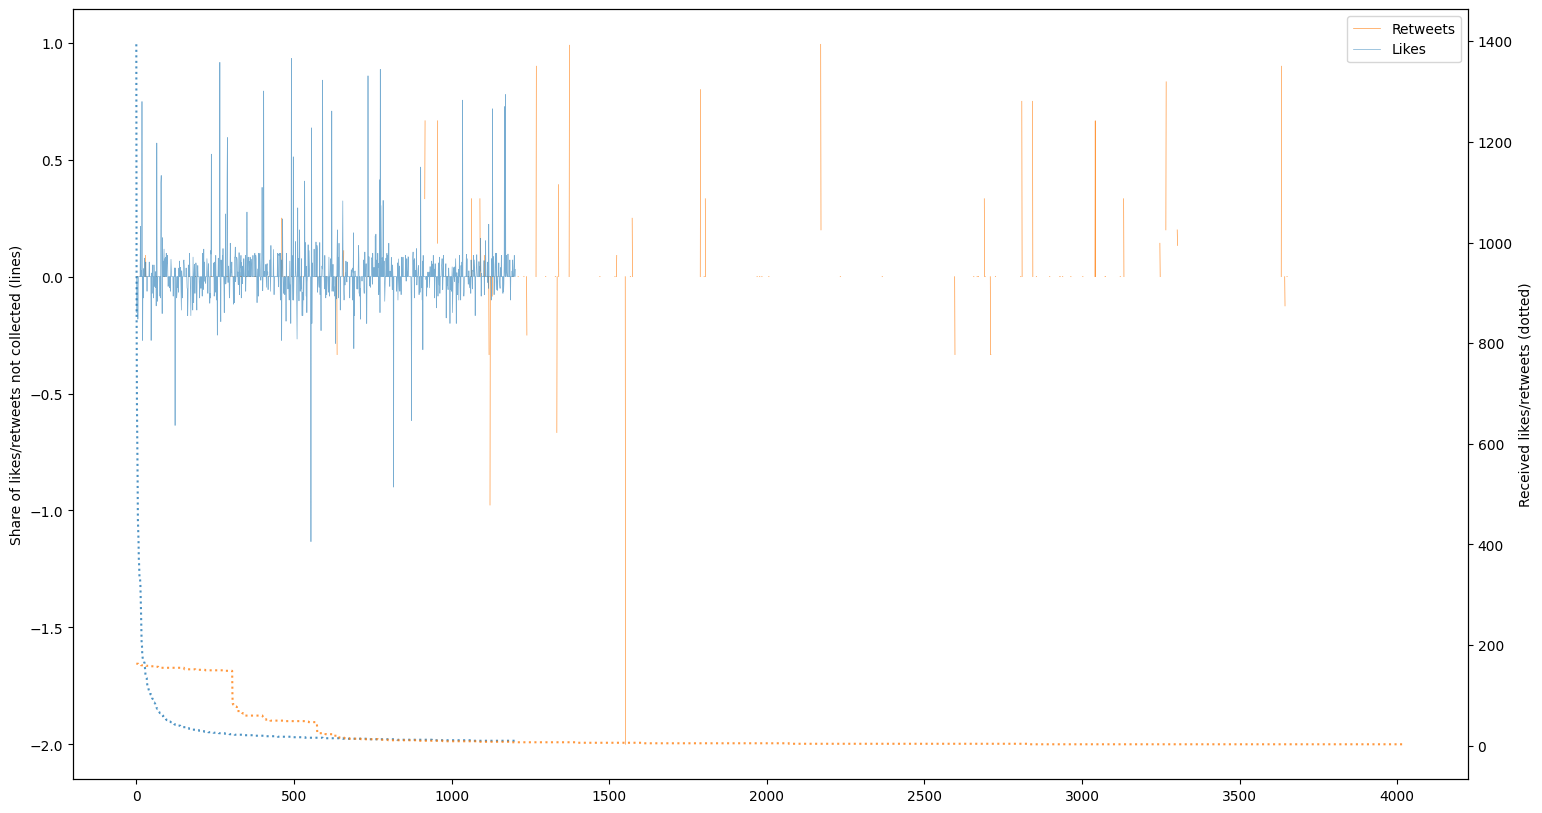

In [12]:
# Supplemented with total number of likes/retweets each tweet attracted: 
plot_missed_relative_absolutecount(likecount, likerscollected, retweetcount, retweeterscollected)


In [13]:
# inspect numbers more closely: likers
d = {'collected likers': likerscollected, 'likecount': likecount, 'difference': likecount-likerscollected, 'percent': ((likecount-likerscollected)/likecount)}
inspectlikes = pd.DataFrame(data=d)
inspectlikes

,collected likers,likecount,difference,percent
tweet,,,,
1537359512163831808,30.0,26,-4.0,-0.153846
1537360344863195136,19.0,19,0.0,0.0
1537360508596195330,11.0,11,0.0,0.0
1537360808321105920,10.0,10,0.0,0.0
1537361053025243136,20.0,20,0.0,0.0
...,...,...,...,...
1538918269511507970,69.0,73,4.0,0.054795
1539139027827318785,10.0,11,1.0,0.090909
1539150351860899841,70.0,74,4.0,0.054054


In [14]:
# inspect numbers more closely: retweeteres
d = {'collected retweeters': retweeterscollected, 'retweetcount': retweetcount, 'difference': retweetcount-retweeterscollected, 'percent': ((retweetcount-retweeterscollected)/retweetcount)}
inspectretweets = pd.DataFrame(data=d)
inspectretweets

,collected retweeters,retweetcount,difference,percent
tweet,,,,
1537359432148996097,NaN,3,NaN,NaN
1537359864279834624,NaN,3,NaN,NaN
1537359992675876864,NaN,6,NaN,NaN
1537360357953511431,3.0,3,0.0,0.0
1537360460525318145,4.0,4,0.0,0.0
...,...,...,...,...
1539152499596218368,NaN,9,NaN,NaN
1539152925867524096,NaN,13,NaN,NaN
1539153220026740738,NaN,3,NaN,NaN


In [15]:
perf = pd.DataFrame()
perf.loc[1, '% tweets with 10 or more too many (deleted):'] = round(len(inspectlikes[inspectlikes['difference'] <-10])/len(inspectlikes),4)
perf.loc[2,'% tweets with 10 or more too many (deleted):'] = round(len(inspectretweets[inspectretweets['difference'] <-10])/len(inspectretweets), 4)

perf.loc[1, '% tweets with 10 or more missed:'] = round(len(inspectlikes[inspectlikes['difference'] >10])/len(inspectlikes),4)
perf.loc[2, '% tweets with 10 or more missed:'] = round(len(inspectretweets[inspectretweets['difference'] >10])/len(inspectretweets),4)

perf.loc[1, '% tweets with 10% or more too many (deleted):'] = round(len(inspectlikes[inspectlikes['percent'] <-.1])/len(inspectlikes),4)
perf.loc[2,'% tweets with 10% or more too many (deleted):'] = round(len(inspectretweets[inspectretweets['percent'] >.1] )/len(inspectretweets),4)


perf.loc[1, '% tweets with 10% or more missed:'] = round(len(inspectlikes[inspectlikes['percent'] >.1])/len(inspectlikes),4)
perf.loc[2, '% tweets with 10% or more missed:'] = round(len(inspectretweets[inspectretweets['percent'] <-.1] )/len(inspectretweets),4)

perf.loc[1, '% tweets with complete:'] = round(len(inspectlikes[inspectlikes['difference'] == 0])/len(inspectlikes),4)
perf.loc[2, '% tweets with complete:'] = round(len(inspectretweets[inspectretweets['difference'] == 0])/len(inspectretweets),4)


perf.index = ['Likes', 'Retweets']

perf

,% tweets with 10 or more too many (deleted):,% tweets with 10 or more missed:,% tweets with 10% or more too many (deleted):,% tweets with 10% or more missed:,% tweets with complete:
Likes,0.0017,0.0324,0.0424,0.0565,0.5436
Retweets,0.0002,0.0027,0.0174,0.0045,0.1339


In [16]:
# Inspect (highly popular) tweets in terms of like count
likecount

tweet
1537739470379925504    1394
1537889632557228033     846
1537834780556939264     680
1537772612989902848     614
1537709471476199424     539
                       ... 
1537435521806258176      10
1537725068016599042      10
1537741827729661953      10
1537426489267826688      10
1537748174017814529      10
Name: like_count, Length: 1203, dtype: object

In [17]:
# Inspect (highly popular) tweets in terms of retweet count
retweetcount

tweet
1538846135846064128    163
1538517733800804353    163
1538850250911277056    163
1538529126436446210    163
1538809336285347841    163
                      ... 
1538171624880492544      3
1538097920330842114      3
1537699324104171522      3
1537436774858780674      3
1538409417498140672      3
Name: retweet_count, Length: 4024, dtype: object

## D. Understanding user activity

### How many likes/retweets did the users place? How many unique likers/retweeters are in the dataset? 

In [18]:
freqtable_l, freqtable_r = make_frequency_table(likers_complete, retweeters_complete)

In [19]:
freqtable_l.head()

,placedlikes,freqlikers
1.0,1.0,5852
2.0,2.0,1785
3.0,3.0,872
4.0,4.0,534
5.0,5.0,367


In [20]:
freqtable_r.head()

,placedretweets,freqretweeters
1.0,1.0,1268
2.0,2.0,283
3.0,3.0,102
4.0,4.0,42
5.0,5.0,37


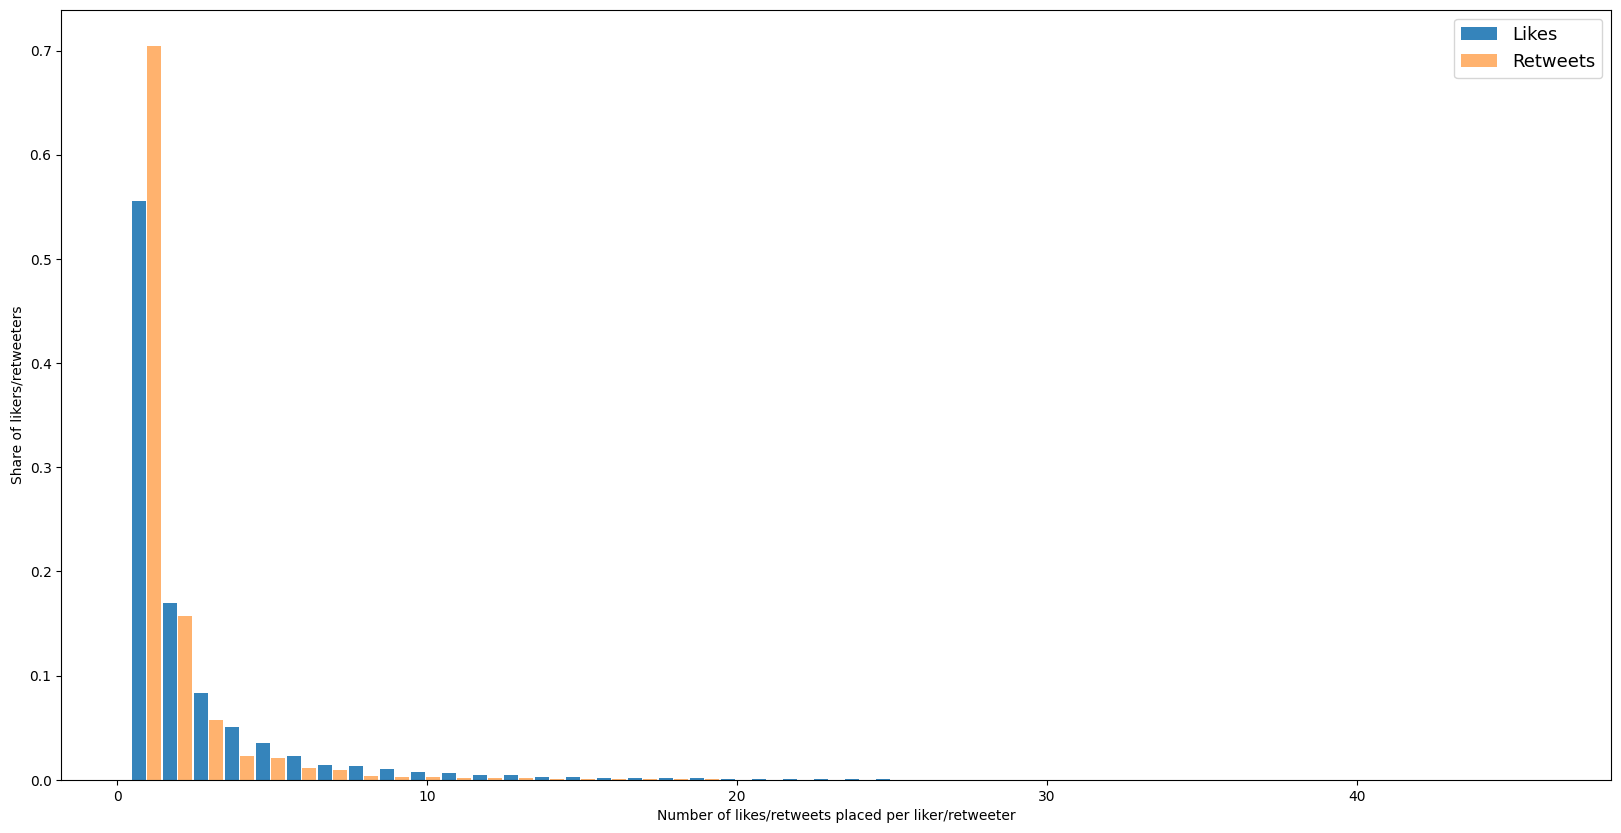

In [21]:
plot_frequency(freqtable_l, freqtable_r)

In [22]:
users = pd.DataFrame()

users.loc[1, 'users placed more than 1:'] = freqtable_l.loc[freqtable_l['placedlikes'] > 1, 'freqlikers'].sum()
users.loc[2,'users placed more than 1:'] = freqtable_r.loc[freqtable_r['placedretweets'] > 1, 'freqretweeters'].sum()

users.loc[1, '% users placed more than 1:'] = round((freqtable_l.loc[freqtable_l['placedlikes'] > 1, 'freqlikers'].sum())/sum(freqtable_l['freqlikers']),4)
users.loc[2, '% users placed more than 1:'] = round((freqtable_r.loc[freqtable_r['placedretweets'] > 1, 'freqretweeters'].sum())/sum(freqtable_r['freqretweeters']),4)

users.loc[1, 'users placed more than 2:'] = freqtable_l.loc[freqtable_l['placedlikes'] > 2, 'freqlikers'].sum()
users.loc[2,'users placed more than 2:'] = freqtable_r.loc[freqtable_r['placedretweets'] > 2, 'freqretweeters'].sum()

users.loc[1, '% users placed more than 2:'] = round((freqtable_l.loc[freqtable_l['placedlikes'] > 2, 'freqlikers'].sum())/sum(freqtable_l['freqlikers']),4)
users.loc[2, '% users placed more than 2:'] = round((freqtable_r.loc[freqtable_r['placedretweets'] > 2, 'freqretweeters'].sum())/sum(freqtable_r['freqretweeters']),4)

users.loc[1, 'users placed more than 3:'] = freqtable_l.loc[freqtable_l['placedlikes'] > 3, 'freqlikers'].sum()
users.loc[2,'users placed more than 3:'] = freqtable_r.loc[freqtable_r['placedretweets'] > 3, 'freqretweeters'].sum()

users.loc[1, '% users placed more than 3:'] = round((freqtable_l.loc[freqtable_l['placedlikes'] > 3, 'freqlikers'].sum())/sum(freqtable_l['freqlikers']),4)
users.loc[2, '% users placed more than 3:'] = round((freqtable_r.loc[freqtable_r['placedretweets'] > 3, 'freqretweeters'].sum())/sum(freqtable_r['freqretweeters']),4)

users.loc[1, 'users placed more than 4:'] = freqtable_l.loc[freqtable_l['placedlikes'] > 4, 'freqlikers'].sum()
users.loc[2,'users placed more than 4:'] = freqtable_r.loc[freqtable_r['placedretweets'] > 4, 'freqretweeters'].sum()

users.loc[1, '% users placed more than 4:'] = round((freqtable_l.loc[freqtable_l['placedlikes'] > 4, 'freqlikers'].sum())/sum(freqtable_l['freqlikers']),4)
users.loc[2, '% users placed more than 4:'] = round((freqtable_r.loc[freqtable_r['placedretweets'] > 4, 'freqretweeters'].sum())/sum(freqtable_r['freqretweeters']),4)

users.loc[1, 'users placed more than 50:'] = freqtable_l.loc[freqtable_l['placedlikes'] > 50, 'freqlikers'].sum()
users.loc[2,'users placed more than 50:'] = freqtable_r.loc[freqtable_r['placedretweets'] > 50, 'freqretweeters'].sum()

users.loc[1, '% users placed more than 50:'] = round((freqtable_l.loc[freqtable_l['placedlikes'] > 50, 'freqlikers'].sum())/sum(freqtable_l['freqlikers']),4)
users.loc[2, '% users placed more than 50:'] = round((freqtable_r.loc[freqtable_r['placedretweets'] > 50, 'freqretweeters'].sum())/sum(freqtable_r['freqretweeters']),4)


users.index = ['Likes', 'Retweets']
users


,users placed more than 1:,% users placed more than 1:,users placed more than 2:,% users placed more than 2:,users placed more than 3:,% users placed more than 3:,users placed more than 4:,% users placed more than 4:,users placed more than 50:,% users placed more than 50:
Likes,4678.0,0.4443,2893.0,0.2747,2021.0,0.1919,1487.0,0.1412,5.0,0.0005
Retweets,534.0,0.2963,251.0,0.1393,149.0,0.0827,107.0,0.0594,1.0,0.0006
